# Segmented Features

To truly achieve a detailed view on the behaviour of the car through Turn 1 and Turn 2, we will take a segmented approach for track in these turns. Specifically, we will divide the track within a carefully chosen startpoint and endpoint (as discussed below) and dynamically spaced distance intervals to extract sampled information including:
- Car position relative to the reference line
- Average speed K/H
- Average Throttle strength
- Average Brake strength
- Lap Distance

The chosen startpoint is determined as follows:

1. Find the distance when the average braking value is first 0.1. (Our initial approach was to take the earliest brake time, however, there were drivers who braked right from the beginning of the track which would not help to focus solely on turn 1 and turn 2)
2. Find the coordinates of a car that has a lap distance closest to the distance found in step 1.
3. Remove all car, reference, left-side and right-side track coordinates with an x-coordinate less than the reference point found in step 2. 


The chosen endpoint will be the reference point when crossing the tangent line (given to us) of Turn 2. Which is determined as follows:

1. Use the corner points provided in the Turns file to determine the straight line/tangent of Turn 2. 
2. Find the reference point on this line. 
3. Remove all car, reference, left-side and right-side track coordinates with an x-coordinate greater than the reference point found in step 2. 

## Set-up

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import f1racing.helper as helper

In [2]:
current_dir = os.getcwd()
f1sim_df = pd.read_csv(os.path.join(current_dir, '..', 'processed_data', 'f1sim_combined.csv'))

f1sim_left = pd.read_csv(os.path.join(current_dir, '..', 'raw_data', 'f1sim-ref-left.csv'))
f1sim_right = pd.read_csv(os.path.join(current_dir, '..', 'raw_data', 'f1sim-ref-right.csv'))

f1sim_line = pd.read_csv(os.path.join(current_dir, '..', 'raw_data', 'f1sim-ref-line.csv'))
f1sim_turns = pd.read_csv(os.path.join(current_dir, '..', 'raw_data', 'f1sim-ref-turns.csv'))

f1sim_df = f1sim_df.drop(['Unnamed: 0'], axis=1)
f1sim_line = f1sim_line.sort_values("FRAME").reset_index(drop=True)

## Determine End-Point

In [3]:
point1 = [f1sim_turns.loc[1].get(3), f1sim_turns.loc[1].get(4)] # get coordinates of Turn 2 CORNER_X1, CORNER_Y1
point2 = [f1sim_turns.loc[1].get(5), f1sim_turns.loc[1].get(6)] # get coordinates of Turn 2 CORNER_X2, CORNER_Y2
ref_line = f1sim_line[['WORLDPOSX', 'WORLDPOSY']].values.tolist()

intersection_point = helper.find_point_intersection(point1, point2, ref_line)
print("Intersection point:", intersection_point)

Intersection point: (374.765893507284, 69.05874151069568)


In [4]:
# Remove coordinates that have a x-coordinate greater than 450
# Even though the reference line cuts through at an x-coordinate of 374, if we filter greater than this we will be excluding part of Turn 1 due to the
# nature of the coordinates in the simulation

# NOTE: FOR THE SEGMENTATION WE WILL CUT OFF AT COORDINATE OF 374 (450 is for basic filtering for now)

f1sim_endpoint_df = f1sim_df[f1sim_df["WORLDPOSX"] < 450]
f1sim_line_endpoint_df = f1sim_line[f1sim_line["WORLDPOSX"] < 450]
f1sim_left_df = f1sim_left[f1sim_left["WORLDPOSX"] < 450]
f1sim_right_df = f1sim_right[f1sim_right["WORLDPOSX"] < 450]
f1sim_endpoint_df

,SESSION_IDENTIFIER,FRAME,LAP_NUM,LAP_DISTANCE,CURRENT_LAP_TIME_MS,SPEED_KPH,THROTTLE,BRAKE,STEERING,WORLDPOSX,WORLDPOSY,LAP_ID
0,1.004645e+19,1652,1,0.580389,0,289.0,0.998413,0.0,0.002243,111.150146,464.910126,1.0046447013921722e+19_1
1,1.004645e+19,1653,1,4.607213,50,290.0,0.998413,0.0,0.001144,114.049080,462.116333,1.0046447013921722e+19_1
2,1.004645e+19,1655,1,9.989393,116,290.0,0.998413,0.0,-0.002426,117.922577,458.380981,1.0046447013921722e+19_1
3,1.004645e+19,1657,1,14.036831,166,290.0,0.988968,0.0,-0.002518,120.835716,455.572235,1.0046447013921722e+19_1
4,1.004645e+19,1659,1,18.079540,216,291.0,0.973739,0.0,-0.003250,123.746330,452.767700,1.0046447013921722e+19_1
...,...,...,...,...,...,...,...,...,...,...,...,...
294405,9.922656e+18,3658,2,625.181641,11227,166.0,0.512398,0.0,-0.008194,442.379700,-13.087651,9.922655568079577e+18_2
294406,9.922656e+18,3659,2,627.505859,11277,167.0,0.513451,0.0,-0.010575,444.125244,-14.615591,9.922655568079577e+18_2
294407,9.922656e+18,3660,2,629.835449,11327,167.0,0.513451,0.0,-0.011856,445.876801,-16.145163,9.922655568079577e+18_2
294408,9.922656e+18,3661,2,632.177734,11378,168.0,0.516609,0.0,-0.005997,447.639648,-17.680723,9.922655568079577e+18_2


## Determine Start-Point

The lap distance segment where the average brake is closest to 0.1: 244.0m


C:\Users\keywo\AppData\Local\Temp/ipykernel_368/1676634126.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f1sim_endpoint_df['LAP_DISTANCE_SEGMENT'] = (f1sim_endpoint_df['LAP_DISTANCE'] // 1) * 1


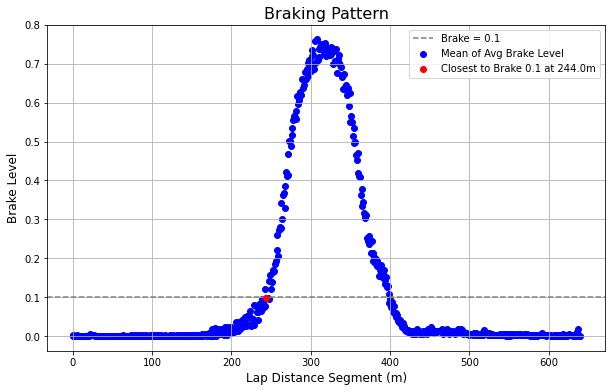

In [5]:
import matplotlib.pyplot as plt

# Create new column for lap distance segments by 1m intervals
f1sim_endpoint_df['LAP_DISTANCE_SEGMENT'] = (f1sim_endpoint_df['LAP_DISTANCE'] // 1) * 1

# Group by SESSION_IDENTIFIER and LAP_DISTANCE_SEGMENT, then calculate brake statistics
grouped_df = f1sim_endpoint_df.groupby(['SESSION_IDENTIFIER', 'LAP_DISTANCE_SEGMENT']).agg({
    'BRAKE': ['min', 'max', 'mean']
}).reset_index()

# Flatten the column names
grouped_df.columns = ['SESSION_IDENTIFIER', 'LAP_DISTANCE_SEGMENT', 'MIN_BRAKE', 'MAX_BRAKE', 'AVG_BRAKE']

# Calculate mean of AVG_BRAKE across all sessions for each lap distance segment
mean_brake_df = grouped_df.groupby('LAP_DISTANCE_SEGMENT')['AVG_BRAKE'].mean().reset_index()
mean_brake_df.columns = ['LAP_DISTANCE_SEGMENT', 'MEAN_AVG_BRAKE']

# Find the lap distance segment where the average brake becomes closest to 0.1
closest_segment = mean_brake_df.iloc[(mean_brake_df['MEAN_AVG_BRAKE'] - 0.1).abs().argmin()]

# Extract lap distance and mean avg brake at that point
lap_distance_at_0_1_brake = closest_segment['LAP_DISTANCE_SEGMENT']
brake_at_closest_segment = closest_segment['MEAN_AVG_BRAKE']

print(f"The lap distance segment where the average brake is closest to 0.1: {lap_distance_at_0_1_brake}m")

# Plot the data
plt.figure(figsize=(10, 6))

# Scatter plot for the mean of avg brake levels at each lap distance segment
plt.scatter(mean_brake_df['LAP_DISTANCE_SEGMENT'], mean_brake_df['MEAN_AVG_BRAKE'], color='b', label='Mean of Avg Brake Level')

# Highlight the segment where brake is closest to 0.1
plt.scatter(lap_distance_at_0_1_brake, brake_at_closest_segment, color='r', label=f'Closest to Brake 0.1 at {lap_distance_at_0_1_brake}m', zorder=5)

# Adding labels and title
plt.title('Braking Pattern', fontsize=16)
plt.xlabel('Lap Distance Segment (m)', fontsize=12)
plt.ylabel('Brake Level', fontsize=12)
plt.axhline(0.1, color='gray', linestyle='--', label='Brake = 0.1')  # Optional: Add horizontal line at brake 0.1
plt.legend()

# Show plot
plt.grid(True)
plt.show()




In [6]:
# We will now look at a car who has a datapoint closest to the distance 244m and use this as the coordinate to do further work with
# Find the row where LAP_DISTANCE is closest to 244
closest_row = f1sim_endpoint_df.iloc[(f1sim_endpoint_df['LAP_DISTANCE'] - 244).abs().argmin()]

coordinates = [closest_row["WORLDPOSX"], closest_row["WORLDPOSY"]]
# Output the row
print(closest_row)
coordinates

SESSION_IDENTIFIER       9380732602589079552.0
FRAME                                     2883
LAP_NUM                                      2
LAP_DISTANCE                        243.996582
CURRENT_LAP_TIME_MS                       2719
SPEED_KPH                                332.0
THROTTLE                                   1.0
BRAKE                                      0.0
STEERING                              0.010934
WORLDPOSX                           288.838135
WORLDPOSY                           298.584869
LAP_ID                  9.38073260258908e+18_2
LAP_DISTANCE_SEGMENT                     243.0
Name: 283764, dtype: object


[288.838134765625, 298.5848693847656]

In [7]:
# Remove coordinates that have a x-coordinate less than 288

f1sim_car_df = f1sim_endpoint_df[f1sim_endpoint_df["WORLDPOSX"] > 288]
line_df = f1sim_line_endpoint_df[f1sim_line_endpoint_df["WORLDPOSX"] > 288]
left_df = f1sim_left_df[f1sim_left_df["WORLDPOSX"] > 288]
right_df = f1sim_right_df[f1sim_right_df["WORLDPOSX"] > 288]
f1sim_car_df


,SESSION_IDENTIFIER,FRAME,LAP_NUM,LAP_DISTANCE,CURRENT_LAP_TIME_MS,SPEED_KPH,THROTTLE,BRAKE,STEERING,WORLDPOSX,WORLDPOSY,LAP_ID,LAP_DISTANCE_SEGMENT
53,1.004645e+19,1722,1,244.538086,2919,309.0,0.962173,0.000000,0.005264,288.571289,297.527161,1.0046447013921722e+19_1,244.0
54,1.004645e+19,1724,1,250.283997,2986,310.0,0.962173,0.000000,0.006638,292.786957,293.626923,1.0046447013921722e+19_1,250.0
55,1.004645e+19,1725,1,254.594437,3036,310.0,0.960082,0.000000,0.007095,295.948090,290.693848,1.0046447013921722e+19_1,254.0
56,1.004645e+19,1726,1,258.908386,3086,310.0,0.955871,0.000000,0.007553,299.107697,287.753998,1.0046447013921722e+19_1,258.0
57,1.004645e+19,1727,1,264.659332,3153,310.0,0.817746,0.070726,0.009384,303.312805,283.827576,1.0046447013921722e+19_1,264.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
294405,9.922656e+18,3658,2,625.181641,11227,166.0,0.512398,0.000000,-0.008194,442.379700,-13.087651,9.922655568079577e+18_2,625.0
294406,9.922656e+18,3659,2,627.505859,11277,167.0,0.513451,0.000000,-0.010575,444.125244,-14.615591,9.922655568079577e+18_2,627.0
294407,9.922656e+18,3660,2,629.835449,11327,167.0,0.513451,0.000000,-0.011856,445.876801,-16.145163,9.922655568079577e+18_2,629.0
294408,9.922656e+18,3661,2,632.177734,11378,168.0,0.516609,0.000000,-0.005997,447.639648,-17.680723,9.922655568079577e+18_2,632.0


## Intervals

In [8]:
# Rough distance covered for the entire segment 
f1sim_car_df["LAP_DISTANCE"].max() - f1sim_car_df["LAP_DISTANCE"].min()

397.03448486328125

In [9]:
# Distance from start point to Turn 1 tangent

point1 = [f1sim_turns.loc[0].get(3), f1sim_turns.loc[0].get(4)] # get coordinates of Turn 1 CORNER_X1, CORNER_Y1
point2 = [f1sim_turns.loc[0].get(5), f1sim_turns.loc[0].get(6)] # get coordinates of Turn 1 CORNER_X2, CORNER_Y2
ref_line = f1sim_line[['WORLDPOSX', 'WORLDPOSY']].values.tolist()

intersection_point = helper.find_point_intersection(point1, point2, ref_line)
print("Intersection point:", intersection_point)

tmp_df = f1sim_car_df[f1sim_car_df["WORLDPOSX"] > 369.3679251348219]
print((f1sim_car_df["LAP_DISTANCE"].max() - f1sim_car_df["LAP_DISTANCE"].min()) - (tmp_df["LAP_DISTANCE"].max() - tmp_df["LAP_DISTANCE"].min()))

Intersection point: (369.3679251348219, 214.47012656116132)
113.33447265625


In [10]:
# Find the distance of the end-point

f1sim_car_df = f1sim_car_df.reset_index(drop=True)
f1sim_car_1 = f1sim_car_df[f1sim_car_df["LAP_ID"] == f1sim_car_df.loc[1].get(11)]


point1 = [f1sim_turns.loc[1].get(3), f1sim_turns.loc[1].get(4)] # get coordinates of Turn 2 CORNER_X1, CORNER_Y1
point2 = [f1sim_turns.loc[1].get(5), f1sim_turns.loc[1].get(6)] # get coordinates of Turn 2 CORNER_X2, CORNER_Y2
ref_line = f1sim_car_1[['WORLDPOSX', 'WORLDPOSY']].values.tolist()

intersection_point = helper.find_point_intersection(point1, point2, ref_line)
print("Intersection point:", intersection_point)

# Given point coordinates (target_x, target_y)
target_x = intersection_point[0]  # Replace with the actual target X value
target_y = intersection_point[1]  # Replace with the actual target Y value

# Calculate the Euclidean distance between each row's WORLDPOSX and WORLDPOSY and the target point
f1sim_car_1['distance_to_point'] = np.sqrt((f1sim_car_1['WORLDPOSX'] - target_x) ** 2 + (f1sim_car_1['WORLDPOSY'] - target_y) ** 2)

# Find the row with the minimum distance
closest_row = f1sim_car_1.iloc[f1sim_car_1['distance_to_point'].idxmin()]

# Output the row
print(closest_row["LAP_DISTANCE"])

Intersection point: (376.16808200135773, 72.96869019609368)
515.20654296875


C:\Users\keywo\AppData\Local\Temp/ipykernel_368/2840708034.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f1sim_car_1['distance_to_point'] = np.sqrt((f1sim_car_1['WORLDPOSX'] - target_x) ** 2 + (f1sim_car_1['WORLDPOSY'] - target_y) ** 2)


In [11]:
# Filter on a lap distance less than 530 (Although we find 515 metres in the last cell we will
# go slightly above as to avoid cutting off any necessary data for later sampling)
f1sim_car_df = f1sim_car_df[f1sim_car_df["LAP_DISTANCE"] < 530]

We will break up the interval into different segments:

Segments will be 242 metres into the track to 516 metres. 

The first 110 metres from the defined startpoint will be the straight leading up to the tanget of Turn 1 - it will not need to be sampled as frequently (10 samples)

The next 5 metres of the track will be segmented every metre or in other words a total of 5 samples (as we are coming to a crucial tangent line of Turn 1 where behaviour of the car will completely influence the success of the turns). 
- brings us 3 metres before the tanget and 2 metres after

The next 65 metres around the apex of Turn 1 will be sampled 10 times.

The next 5 metres of the track will be segmented every metre in other words sampled 5 times (as we transition from the turning radius of Turn 1 to Turn 2).

The next 88 metres around the apex of Turn 2 will be sampled 10 times. 

## Finding the common radius line between Turn 1 and Turn 2 and the Reference Point on the line

In [12]:
# For the common radius Line
point1 = [f1sim_turns.loc[0].get(3), f1sim_turns.loc[0].get(4)] # get coordinates of Turn 2 CORNER_X1, CORNER_Y1
point2 = [f1sim_turns.loc[1].get(5), f1sim_turns.loc[1].get(6)] # get coordinates of Turn 2 CORNER_X2, CORNER_Y2
ref_line = f1sim_line[['WORLDPOSX', 'WORLDPOSY']].values.tolist()

print(point1, point2)

intersection_point_common_line = helper.find_point_intersection(point1, point2, ref_line)
print("Intersection point:", intersection_point_common_line)

[315.0, 145.0] [402.0, 145.0]
Intersection point: (372.5054486876702, 145.0)


In [13]:
point1 = [f1sim_turns.loc[0].get(3), f1sim_turns.loc[0].get(4)] # get coordinates of Turn 2 CORNER_X1, CORNER_Y1
point2 = [f1sim_turns.loc[0].get(5), f1sim_turns.loc[0].get(6)] # get coordinates of Turn 2 CORNER_X2, CORNER_Y2
ref_line = f1sim_line[['WORLDPOSX', 'WORLDPOSY']].values.tolist()

intersection_point_turn2 = helper.find_point_intersection(point1, point2, ref_line)
print("Intersection point:", intersection_point_turn2)

Intersection point: (369.3679251348219, 214.47012656116132)


In [14]:
helper.distance_formula(intersection_point_common_line, intersection_point_turn2)

69.54094145514891

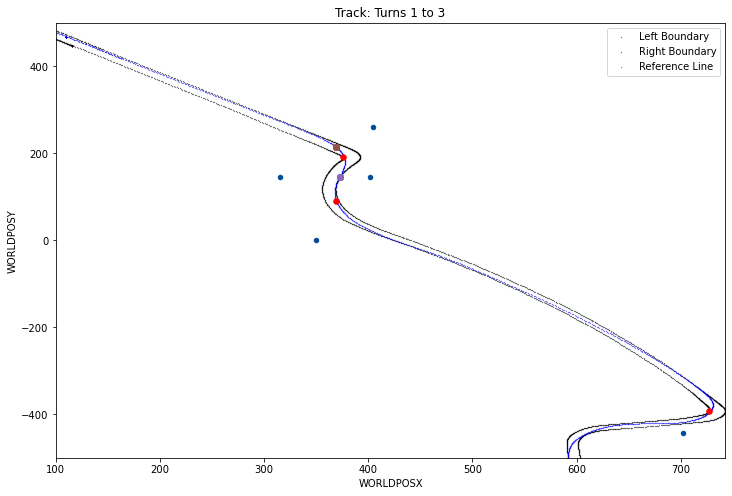

In [15]:
turns_of_interest = f1sim_turns[(f1sim_turns['TURN'] >= 1) & (f1sim_turns['TURN'] <= 3)]

# Plot track boundaries
plt.figure(figsize=(12, 8))
plt.scatter(f1sim_left['WORLDPOSX'], f1sim_left['WORLDPOSY'], c='black', label='Left Boundary', s=0.05)
plt.scatter(f1sim_right['WORLDPOSX'], f1sim_right['WORLDPOSY'], c='black', label='Right Boundary', s=0.05)
plt.scatter(f1sim_line["WORLDPOSX"], f1sim_line["WORLDPOSY"], c='blue', label='Reference Line', s=0.05)

# Annotate apex and corners with points
for i, row in turns_of_interest.iterrows():
    offset = (-60, 60) if i < len(turns_of_interest) // 2 else (60, -50)
    
    # Plot point at the apex and annotate it
    plt.scatter(row['APEX_X1'], row['APEX_Y1'], color='red', s=30)  # Plot apex point
    # plt.annotate(f"Turn {int(row['TURN'])} Apex", xy=(row['APEX_X1'], row['APEX_Y1']), 
    #              xytext=offset, textcoords="offset points", ha='center', fontsize=11, color='red', weight='bold',
    #              arrowprops=dict(facecolor='red', shrink=0.05))

    # Plot points for Corner 1 and Corner 2 and annotate them
    plt.scatter(row['CORNER_X1'], row['CORNER_Y1'], color='#004C99', s=20)  # Corner 1 point
    # plt.annotate(f"Turn {int(row['TURN'])} Corner 1", (row['CORNER_X1'], row['CORNER_Y1']), 
    #              textcoords="offset points", xytext=(0, 10), ha='center', fontsize=7, color='#004C99')
    
    plt.scatter(row['CORNER_X2'], row['CORNER_Y2'], color='#004C99', s=20)  # Corner 2 point
    # plt.annotate(f"Turn {int(row['TURN'])} Corner 2", (row['CORNER_X2'], row['CORNER_Y2']), 
    #              textcoords="offset points", xytext=(0, 10), ha='center', fontsize=7, color='#004C99')
    
    plt.scatter(intersection_point_common_line[0], intersection_point_common_line[1])
    plt.scatter(intersection_point_turn2[0], intersection_point_turn2[1])

# Set labels, title, and limits
plt.xlabel('WORLDPOSX')
plt.ylabel('WORLDPOSY')
plt.title('Track: Turns 1 to 3')
plt.xlim(100, f1sim_left['WORLDPOSX'].max())  # Set x limit to start from 100
plt.ylim(-500, 500)  # Set y limit from -500 to 600
plt.legend()
plt.show()

## Sampling

We will break up the interval into different segments:

Segments will be 242 metres into the track to 516 metres. 

The first 110 metres from the defined startpoint will be the straight leading up to the tanget of Turn 1 - it will not need to be segmented as frequently (every 10 metres)

The next 5 metres of the track will be segmented every metre (as we are coming to a crucial tangent line of Turn 1 where behaviour of the car will completely influence the success of the turns). 
- brings us 3 metres before the tanget and 2 metres after

The next 65 metres around the apex of Turn 1 sampled 10 times, or rougly every 6.5 metres. 

The next 5 metres of the track will be segmented every metre (as we transition from the turning radius of Turn 1 to Turn 2)

The next 88 metres around the apex of Turn 2 will be segmented every 5 metres (rougly the car's length)

In [16]:
f1sim_left_df = f1sim_left.sort_values("FRAME").reset_index(drop=True)
# Select only the required columns and drop duplicates
f1sim_left_df = f1sim_left_df[["WORLDPOSX", "WORLDPOSY"]].drop_duplicates()

# Filter rows with the corrected coordinates that lie between the start line and midpoint of Turn 2 and Turn 3
f1sim_left_df = f1sim_left_df[
    (f1sim_left_df["WORLDPOSX"] <= 700) & 
    (f1sim_left_df["WORLDPOSX"] >= 100) & 
    (f1sim_left_df["WORLDPOSY"] <= 500) & 
    (f1sim_left_df["WORLDPOSY"] >= -500)
]

# cut off left and right reference line 

f1sim_right_df = f1sim_right.sort_values("FRAME").reset_index(drop=True)
f1sim_right_df = f1sim_right[["WORLDPOSX", "WORLDPOSY"]].drop_duplicates()

f1sim_right_df = f1sim_right_df[
    (f1sim_right_df["WORLDPOSX"] <= 700) & 
    (f1sim_right_df["WORLDPOSX"] >= 100) & 
    (f1sim_right_df["WORLDPOSY"] <= 500) & 
    (f1sim_right_df["WORLDPOSY"] >= -500)
]

f1sim_line_df = f1sim_line.sort_values("FRAME").reset_index(drop=True)
f1sim_line_df = f1sim_line_df[["WORLDPOSX", "WORLDPOSY"]].drop_duplicates()

f1sim_line_df = f1sim_line_df[
    (f1sim_line_df["WORLDPOSX"] <= 700) & 
    (f1sim_line_df["WORLDPOSX"] >= 100) & 
    (f1sim_line_df["WORLDPOSY"] <= 500) & 
    (f1sim_line_df["WORLDPOSY"] >= -500)
]

### Segment 1 - First ~ 110 metres from 242 metres into the track (we will take 11 samples)

1. First find when the car crosses the first tangent line and then use the coordinates to work backwards 3 metres
2. Then sample every 10 metres starting at the point found in step 1

In [17]:
f1sim_car_df['INDEX'] = f1sim_car_df.groupby(['SESSION_IDENTIFIER', 'LAP_NUM']).ngroup()

In [18]:
intersection_turn1_points = helper.find_all_car_intersection_points_and_closest_points(f1sim_car_df, f1sim_turns, 0, 0)

In [19]:
segments, graphing = helper.generate_segment_data(f1sim_car_df, 
                             intersection_turn1_points, 
                             intersection_turn1_points, 
                             f1sim_line_df,
                             f1sim_left_df,
                             f1sim_right_df,
                             segment_name="STRAIGHT", 
                             offset_start=0, 
                             offset_end=-3, 
                             interval_samples=10, 
                             segment_num=1)

In [20]:
segment_df = pd.DataFrame(segments).T
segment_df

,INDEX,BRAKE_STRAIGHTSEGMENT1,THROTTLE_STRAIGHTSEGMENT1,STEERING_STRAIGHTSEGMENT1,SPEED_KPH_STRAIGHTSEGMENT1,DISTANCE_FROM_REFLINE_STRAIGHTSEGMENT1,DISTANCE_FROM_LEFT_STRAIGHTSEGMENT1,DISTANCE_FROM_RIGHT_STRAIGHTSEGMENT1,LAP_DISTANCE_STRAIGHTSEGMENT1,BRAKE_STRAIGHTSEGMENT2,...,DISTANCE_FROM_RIGHT_STRAIGHTSEGMENT9,LAP_DISTANCE_STRAIGHTSEGMENT9,BRAKE_STRAIGHTSEGMENT10,THROTTLE_STRAIGHTSEGMENT10,STEERING_STRAIGHTSEGMENT10,SPEED_KPH_STRAIGHTSEGMENT10,DISTANCE_FROM_REFLINE_STRAIGHTSEGMENT10,DISTANCE_FROM_LEFT_STRAIGHTSEGMENT10,DISTANCE_FROM_RIGHT_STRAIGHTSEGMENT10,LAP_DISTANCE_STRAIGHTSEGMENT10
388,388.0,0.000000,0.962173,0.005264,309.0,1.100726,-2.786185,-11.592266,244.538086,0.000000,...,-12.391217,343.298950,0.000000,0.266270,0.152667,163.0,0.369392,-4.908150,11.526033,355.278992
389,389.0,0.000000,1.000000,-0.004257,315.0,-0.453970,2.141060,12.210894,243.563965,0.000000,...,-10.568976,345.305664,0.000000,0.438010,0.237263,159.0,-1.895697,7.902088,8.641368,357.551270
390,390.0,0.000000,1.000000,0.005814,316.0,0.167051,1.850105,-12.588589,246.681641,0.064729,...,11.989355,345.150391,0.000000,0.717952,0.199451,161.0,-1.374505,-7.246874,-9.279213,357.174805
391,391.0,0.000000,0.976471,0.002251,324.0,-0.256447,1.939222,-12.509152,247.017883,0.145098,...,-11.399479,345.237183,0.309804,0.011765,0.235180,153.0,-0.760720,6.859946,-9.703105,358.018982
392,392.0,0.000000,1.000000,0.001335,324.0,0.657918,-2.344151,12.018500,243.964355,0.000000,...,12.500647,342.732422,0.976471,0.000000,0.251354,173.0,0.177855,5.783500,-10.706145,356.413574
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
371,371.0,0.003983,1.000000,-0.011490,330.0,0.444028,-2.129865,12.240697,244.254883,0.309682,...,11.734314,344.845703,0.132845,0.146120,0.265827,156.0,0.840798,-7.037469,9.538486,358.325195
375,375.0,0.133074,0.000000,-0.000687,281.0,0.223271,-1.908652,-12.471050,244.589645,0.266148,...,13.474462,342.599274,0.753491,0.000000,0.038590,176.0,2.211148,-3.085289,-13.362070,355.581116
376,376.0,0.000000,1.000000,-0.018357,329.0,-0.153643,1.841155,-12.505534,243.366699,0.140078,...,-12.616186,342.100586,0.188098,0.000000,0.238178,160.0,0.074828,-5.428629,11.044698,356.076172
377,377.0,0.000000,0.398413,0.002701,251.0,-0.431949,2.119088,12.232247,243.540604,0.000000,...,-9.951460,342.889771,0.067018,0.000000,0.141680,203.0,3.061948,8.950053,-7.569005,356.990753


In [21]:
x_coords = [sublist[0] for sublist in graphing]
y_coords = [sublist[1] for sublist in graphing]

In [22]:
len(x_coords)

10

In [23]:
tmp_df = f1sim_car_df[f1sim_car_df['INDEX'] == 253]
tmp_df.iloc[0]["LAP_ID"]
# helper.plot_track_with_turns(f1sim_left_df, f1sim_right_df, f1sim_turns, 1, 3, f1sim_line, tmp_df["WORLDPOSX"], tmp_df["WORLDPOSY"])

'6.641691466299384e+18_1'

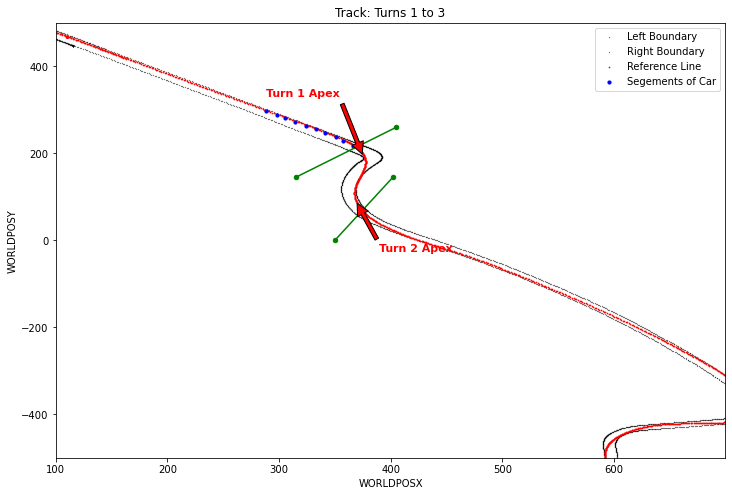

In [24]:
helper.plot_track_with_turns(f1sim_left_df, f1sim_right_df, f1sim_turns, 1, 3, f1sim_line, x_coords, y_coords)

### Segment 2 - Next ~ 5 metres around the tangent of Turn 1

In [25]:
segments, graphing = helper.generate_segment_data(f1sim_car_df, 
                             intersection_turn1_points, 
                             intersection_turn1_points, 
                             f1sim_line_df,
                             f1sim_left_df,
                             f1sim_right_df,
                             segment_name="TURN1", 
                             offset_start=-2, 
                             offset_end=2, 
                             interval_samples=5, 
                             segment_num=2)

In [26]:
turn1_segment_df = pd.DataFrame(segments).T
turn1_segment_df

,INDEX,BRAKE_TURN1SEGMENT1,THROTTLE_TURN1SEGMENT1,STEERING_TURN1SEGMENT1,SPEED_KPH_TURN1SEGMENT1,DISTANCE_FROM_REFLINE_TURN1SEGMENT1,DISTANCE_FROM_LEFT_TURN1SEGMENT1,DISTANCE_FROM_RIGHT_TURN1SEGMENT1,LAP_DISTANCE_TURN1SEGMENT1,BRAKE_TURN1SEGMENT2,...,DISTANCE_FROM_RIGHT_TURN1SEGMENT4,LAP_DISTANCE_TURN1SEGMENT4,BRAKE_TURN1SEGMENT5,THROTTLE_TURN1SEGMENT5,STEERING_TURN1SEGMENT5,SPEED_KPH_TURN1SEGMENT5,DISTANCE_FROM_REFLINE_TURN1SEGMENT5,DISTANCE_FROM_LEFT_TURN1SEGMENT5,DISTANCE_FROM_RIGHT_TURN1SEGMENT5,LAP_DISTANCE_TURN1SEGMENT5
388,388.0,0.000000,0.266270,0.152667,163.0,0.369392,-4.908150,11.526033,355.278992,0.000000,...,11.123008,358.252197,0.000000,0.273106,0.191211,163.0,-0.895778,-5.906099,10.748856,360.478943
389,389.0,0.000000,0.438010,0.237263,159.0,-1.895697,7.902088,8.641368,357.551270,0.000000,...,8.115920,359.684570,0.000000,0.283604,0.222522,160.0,-1.757363,9.180130,-7.513386,361.808105
390,390.0,0.000000,0.717952,0.199451,161.0,-1.374505,-7.246874,-9.279213,357.174805,0.000000,...,-7.770533,361.378906,0.000000,0.789380,0.102129,163.0,-1.651812,8.912086,-7.770533,361.378906
391,391.0,0.309804,0.011765,0.235180,153.0,-0.760720,6.859946,-9.703105,358.018982,0.121569,...,-9.270131,360.076752,0.058824,0.027451,0.317273,150.0,0.484153,7.932365,8.767693,362.102142
392,392.0,0.976471,0.000000,0.251354,173.0,0.177855,5.783500,-10.706145,356.413574,0.976471,...,-10.054263,359.473145,0.976471,0.000000,0.374952,163.0,0.059984,7.201576,9.488224,361.680664
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
371,371.0,0.132845,0.146120,0.265827,156.0,0.840798,-7.037469,9.538486,358.325195,0.062898,...,8.969581,360.402344,0.000000,0.179919,0.305562,155.0,0.786822,-8.386659,-8.321358,362.458008
375,375.0,0.753491,0.000000,0.038590,176.0,2.211148,-3.085289,-13.362070,355.581116,0.763470,...,-13.296847,357.984009,0.785489,0.000000,0.040696,166.0,-3.191680,3.443660,-13.205498,360.322876
376,376.0,0.188098,0.000000,0.238178,160.0,0.074828,-5.428629,11.044698,356.076172,0.063035,...,10.593516,358.220215,0.000000,0.138247,0.237995,157.0,0.208799,6.581244,10.069408,360.333984
377,377.0,0.067018,0.000000,0.141680,203.0,3.061948,8.950053,-7.569005,356.990753,0.000000,...,6.917570,359.712372,0.000000,0.000000,0.159442,201.0,2.804803,-10.524269,-6.183052,362.402863


In [27]:
x_coords = x_coords + [sublist[0] for sublist in graphing]
y_coords = y_coords + [sublist[1] for sublist in graphing]

In [28]:
len(x_coords)

15

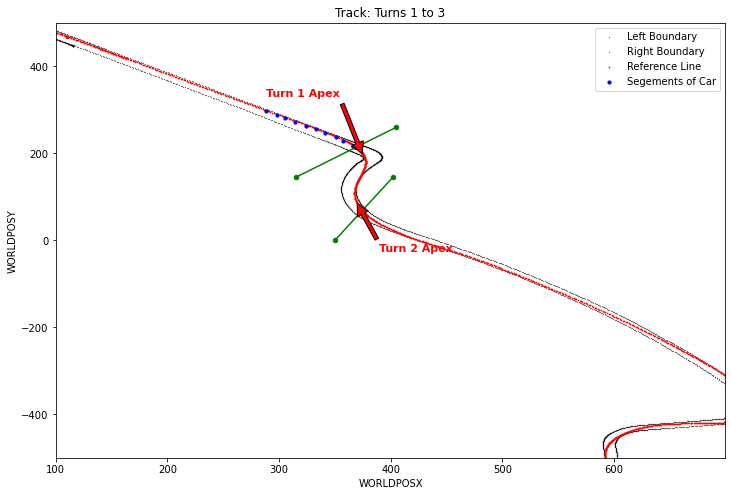

In [29]:
helper.plot_track_with_turns(f1sim_left_df, f1sim_right_df, f1sim_turns, 1, 3, f1sim_line, x_coords, y_coords)

In [30]:
f1sim_car_df
map_df = f1sim_car_df[["INDEX", "LAP_ID", "SESSION_IDENTIFIER", "LAP_NUM"]]
map_df = map_df.drop_duplicates()
map_df.reset_index(drop=True)

combined_segment_df = pd.merge(segment_df, map_df, on='INDEX', how='inner')
combined_segment_df = pd.merge(combined_segment_df, turn1_segment_df, on='INDEX', how='inner')
combined_segment_df


,INDEX,BRAKE_STRAIGHTSEGMENT1,THROTTLE_STRAIGHTSEGMENT1,STEERING_STRAIGHTSEGMENT1,SPEED_KPH_STRAIGHTSEGMENT1,DISTANCE_FROM_REFLINE_STRAIGHTSEGMENT1,DISTANCE_FROM_LEFT_STRAIGHTSEGMENT1,DISTANCE_FROM_RIGHT_STRAIGHTSEGMENT1,LAP_DISTANCE_STRAIGHTSEGMENT1,BRAKE_STRAIGHTSEGMENT2,...,DISTANCE_FROM_RIGHT_TURN1SEGMENT4,LAP_DISTANCE_TURN1SEGMENT4,BRAKE_TURN1SEGMENT5,THROTTLE_TURN1SEGMENT5,STEERING_TURN1SEGMENT5,SPEED_KPH_TURN1SEGMENT5,DISTANCE_FROM_REFLINE_TURN1SEGMENT5,DISTANCE_FROM_LEFT_TURN1SEGMENT5,DISTANCE_FROM_RIGHT_TURN1SEGMENT5,LAP_DISTANCE_TURN1SEGMENT5
0,388.0,0.000000,0.962173,0.005264,309.0,1.100726,-2.786185,-11.592266,244.538086,0.000000,...,11.123008,358.252197,0.000000,0.273106,0.191211,163.0,-0.895778,-5.906099,10.748856,360.478943
1,389.0,0.000000,1.000000,-0.004257,315.0,-0.453970,2.141060,12.210894,243.563965,0.000000,...,8.115920,359.684570,0.000000,0.283604,0.222522,160.0,-1.757363,9.180130,-7.513386,361.808105
2,390.0,0.000000,1.000000,0.005814,316.0,0.167051,1.850105,-12.588589,246.681641,0.064729,...,-7.770533,361.378906,0.000000,0.789380,0.102129,163.0,-1.651812,8.912086,-7.770533,361.378906
3,391.0,0.000000,0.976471,0.002251,324.0,-0.256447,1.939222,-12.509152,247.017883,0.145098,...,-9.270131,360.076752,0.058824,0.027451,0.317273,150.0,0.484153,7.932365,8.767693,362.102142
4,392.0,0.000000,1.000000,0.001335,324.0,0.657918,-2.344151,12.018500,243.964355,0.000000,...,-10.054263,359.473145,0.976471,0.000000,0.374952,163.0,0.059984,7.201576,9.488224,361.680664
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
749,371.0,0.003983,1.000000,-0.011490,330.0,0.444028,-2.129865,12.240697,244.254883,0.309682,...,8.969581,360.402344,0.000000,0.179919,0.305562,155.0,0.786822,-8.386659,-8.321358,362.458008
750,375.0,0.133074,0.000000,-0.000687,281.0,0.223271,-1.908652,-12.471050,244.589645,0.266148,...,-13.296847,357.984009,0.785489,0.000000,0.040696,166.0,-3.191680,3.443660,-13.205498,360.322876
751,376.0,0.000000,1.000000,-0.018357,329.0,-0.153643,1.841155,-12.505534,243.366699,0.140078,...,10.593516,358.220215,0.000000,0.138247,0.237995,157.0,0.208799,6.581244,10.069408,360.333984
752,377.0,0.000000,0.398413,0.002701,251.0,-0.431949,2.119088,12.232247,243.540604,0.000000,...,6.917570,359.712372,0.000000,0.000000,0.159442,201.0,2.804803,-10.524269,-6.183052,362.402863


### Segment 3 - The next 65 metres around the apex of Turn 1 sampled 10 times, or rougly every 6.5 metres (approx. 1.5 metres more than the length of the car)

In [31]:
intersection_common_radial_points = helper.find_all_car_intersection_points_and_closest_points(f1sim_car_df, f1sim_turns, 0, 1)

In [32]:
segments, graphing = helper.generate_segment_data(f1sim_car_df, 
                             intersection_turn1_points, 
                             intersection_turn1_points, 
                             f1sim_line_df,
                             f1sim_left_df,
                             f1sim_right_df,
                             segment_name="TURN1APEX", 
                             offset_start=2, 
                             offset_end=-3, 
                             interval_samples=10, 
                             segment_num=3)

In [33]:
turn1_apex_segment_df = pd.DataFrame(segments).T
turn1_apex_segment_df

,INDEX,BRAKE_TURN1APEXSEGMENT1,THROTTLE_TURN1APEXSEGMENT1,STEERING_TURN1APEXSEGMENT1,SPEED_KPH_TURN1APEXSEGMENT1,DISTANCE_FROM_REFLINE_TURN1APEXSEGMENT1,DISTANCE_FROM_LEFT_TURN1APEXSEGMENT1,DISTANCE_FROM_RIGHT_TURN1APEXSEGMENT1,LAP_DISTANCE_TURN1APEXSEGMENT1,BRAKE_TURN1APEXSEGMENT2,...,DISTANCE_FROM_RIGHT_TURN1APEXSEGMENT9,LAP_DISTANCE_TURN1APEXSEGMENT9,BRAKE_TURN1APEXSEGMENT10,THROTTLE_TURN1APEXSEGMENT10,STEERING_TURN1APEXSEGMENT10,SPEED_KPH_TURN1APEXSEGMENT10,DISTANCE_FROM_REFLINE_TURN1APEXSEGMENT10,DISTANCE_FROM_LEFT_TURN1APEXSEGMENT10,DISTANCE_FROM_RIGHT_TURN1APEXSEGMENT10,LAP_DISTANCE_TURN1APEXSEGMENT10
388,388.0,0.000000,0.273106,0.191211,163.0,-0.895778,-5.906099,10.748856,360.478943,0.000000,...,11.526033,355.278992,0.000000,0.266270,0.152667,163.0,0.369392,-4.908150,11.526033,355.278992
389,389.0,0.000000,0.283604,0.222522,160.0,-1.757363,9.180130,-7.513386,361.808105,0.000000,...,8.641368,357.551270,0.000000,0.438010,0.237263,159.0,-1.895697,7.902088,8.641368,357.551270
390,390.0,0.000000,0.789380,0.102129,163.0,-1.651812,8.912086,-7.770533,361.378906,0.000000,...,-9.279213,357.174805,0.000000,0.717952,0.199451,161.0,-1.374505,-7.246874,-9.279213,357.174805
391,391.0,0.058824,0.027451,0.317273,150.0,0.484153,7.932365,8.767693,362.102142,0.058824,...,-9.703105,358.018982,0.309804,0.011765,0.235180,153.0,-0.760720,6.859946,-9.703105,358.018982
392,392.0,0.976471,0.000000,0.374952,163.0,0.059984,7.201576,9.488224,361.680664,0.976471,...,-10.706145,356.413574,0.976471,0.000000,0.251354,173.0,0.177855,5.783500,-10.706145,356.413574
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
371,371.0,0.000000,0.179919,0.305562,155.0,0.786822,-8.386659,-8.321358,362.458008,0.000000,...,9.538486,358.325195,0.132845,0.146120,0.265827,156.0,0.840798,-7.037469,9.538486,358.325195
375,375.0,0.785489,0.000000,0.040696,166.0,-3.191680,3.443660,-13.205498,360.322876,0.785489,...,-13.362070,355.581116,0.753491,0.000000,0.038590,176.0,2.211148,-3.085289,-13.362070,355.581116
376,376.0,0.000000,0.138247,0.237995,157.0,0.208799,6.581244,10.069408,360.333984,0.000000,...,11.044698,356.076172,0.188098,0.000000,0.238178,160.0,0.074828,-5.428629,11.044698,356.076172
377,377.0,0.000000,0.000000,0.159442,201.0,2.804803,-10.524269,-6.183052,362.402863,0.000000,...,-7.569005,356.990753,0.067018,0.000000,0.141680,203.0,3.061948,8.950053,-7.569005,356.990753


In [34]:
x_coords = x_coords + [sublist[0] for sublist in graphing]
y_coords = y_coords + [sublist[1] for sublist in graphing]

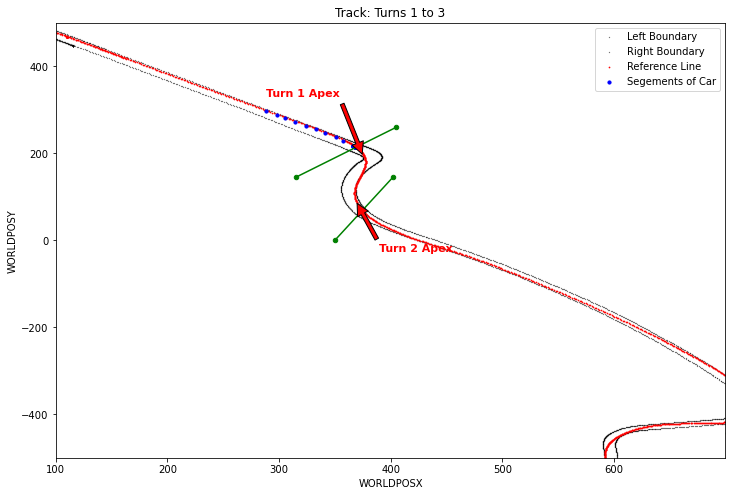

In [35]:
helper.plot_track_with_turns(f1sim_left_df, f1sim_right_df, f1sim_turns, 1, 3, f1sim_line, x_coords, y_coords)

In [36]:
combined_segment_df = pd.merge(combined_segment_df, turn1_apex_segment_df, on='INDEX', how='inner')
combined_segment_df

,INDEX,BRAKE_STRAIGHTSEGMENT1,THROTTLE_STRAIGHTSEGMENT1,STEERING_STRAIGHTSEGMENT1,SPEED_KPH_STRAIGHTSEGMENT1,DISTANCE_FROM_REFLINE_STRAIGHTSEGMENT1,DISTANCE_FROM_LEFT_STRAIGHTSEGMENT1,DISTANCE_FROM_RIGHT_STRAIGHTSEGMENT1,LAP_DISTANCE_STRAIGHTSEGMENT1,BRAKE_STRAIGHTSEGMENT2,...,DISTANCE_FROM_RIGHT_TURN1APEXSEGMENT9,LAP_DISTANCE_TURN1APEXSEGMENT9,BRAKE_TURN1APEXSEGMENT10,THROTTLE_TURN1APEXSEGMENT10,STEERING_TURN1APEXSEGMENT10,SPEED_KPH_TURN1APEXSEGMENT10,DISTANCE_FROM_REFLINE_TURN1APEXSEGMENT10,DISTANCE_FROM_LEFT_TURN1APEXSEGMENT10,DISTANCE_FROM_RIGHT_TURN1APEXSEGMENT10,LAP_DISTANCE_TURN1APEXSEGMENT10
0,388.0,0.000000,0.962173,0.005264,309.0,1.100726,-2.786185,-11.592266,244.538086,0.000000,...,11.526033,355.278992,0.000000,0.266270,0.152667,163.0,0.369392,-4.908150,11.526033,355.278992
1,389.0,0.000000,1.000000,-0.004257,315.0,-0.453970,2.141060,12.210894,243.563965,0.000000,...,8.641368,357.551270,0.000000,0.438010,0.237263,159.0,-1.895697,7.902088,8.641368,357.551270
2,390.0,0.000000,1.000000,0.005814,316.0,0.167051,1.850105,-12.588589,246.681641,0.064729,...,-9.279213,357.174805,0.000000,0.717952,0.199451,161.0,-1.374505,-7.246874,-9.279213,357.174805
3,391.0,0.000000,0.976471,0.002251,324.0,-0.256447,1.939222,-12.509152,247.017883,0.145098,...,-9.703105,358.018982,0.309804,0.011765,0.235180,153.0,-0.760720,6.859946,-9.703105,358.018982
4,392.0,0.000000,1.000000,0.001335,324.0,0.657918,-2.344151,12.018500,243.964355,0.000000,...,-10.706145,356.413574,0.976471,0.000000,0.251354,173.0,0.177855,5.783500,-10.706145,356.413574
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
749,371.0,0.003983,1.000000,-0.011490,330.0,0.444028,-2.129865,12.240697,244.254883,0.309682,...,9.538486,358.325195,0.132845,0.146120,0.265827,156.0,0.840798,-7.037469,9.538486,358.325195
750,375.0,0.133074,0.000000,-0.000687,281.0,0.223271,-1.908652,-12.471050,244.589645,0.266148,...,-13.362070,355.581116,0.753491,0.000000,0.038590,176.0,2.211148,-3.085289,-13.362070,355.581116
751,376.0,0.000000,1.000000,-0.018357,329.0,-0.153643,1.841155,-12.505534,243.366699,0.140078,...,11.044698,356.076172,0.188098,0.000000,0.238178,160.0,0.074828,-5.428629,11.044698,356.076172
752,377.0,0.000000,0.398413,0.002701,251.0,-0.431949,2.119088,12.232247,243.540604,0.000000,...,-7.569005,356.990753,0.067018,0.000000,0.141680,203.0,3.061948,8.950053,-7.569005,356.990753


### Segement 4 - The next 5 metres of the track will be segmented every metre (as we transition from the turning radius of Turn 1 to Turn 2)

In [37]:
segments, graphing = helper.generate_segment_data(f1sim_car_df, 
                             intersection_turn1_points, 
                             intersection_turn1_points, 
                             f1sim_line_df,
                             f1sim_left_df,
                             f1sim_right_df,
                             segment_name="TURNSRADIAL", 
                             offset_start=-2, 
                             offset_end=2, 
                             interval_samples=5, 
                             segment_num=4)

In [38]:
turns_radial_segment_df = pd.DataFrame(segments).T
turns_radial_segment_df

,INDEX,BRAKE_TURNSRADIALSEGMENT1,THROTTLE_TURNSRADIALSEGMENT1,STEERING_TURNSRADIALSEGMENT1,SPEED_KPH_TURNSRADIALSEGMENT1,DISTANCE_FROM_REFLINE_TURNSRADIALSEGMENT1,DISTANCE_FROM_LEFT_TURNSRADIALSEGMENT1,DISTANCE_FROM_RIGHT_TURNSRADIALSEGMENT1,LAP_DISTANCE_TURNSRADIALSEGMENT1,BRAKE_TURNSRADIALSEGMENT2,...,DISTANCE_FROM_RIGHT_TURNSRADIALSEGMENT4,LAP_DISTANCE_TURNSRADIALSEGMENT4,BRAKE_TURNSRADIALSEGMENT5,THROTTLE_TURNSRADIALSEGMENT5,STEERING_TURNSRADIALSEGMENT5,SPEED_KPH_TURNSRADIALSEGMENT5,DISTANCE_FROM_REFLINE_TURNSRADIALSEGMENT5,DISTANCE_FROM_LEFT_TURNSRADIALSEGMENT5,DISTANCE_FROM_RIGHT_TURNSRADIALSEGMENT5,LAP_DISTANCE_TURNSRADIALSEGMENT5
388,388.0,0.000000,0.266270,0.152667,163.0,0.369392,-4.908150,11.526033,355.278992,0.000000,...,11.123008,358.252197,0.000000,0.273106,0.191211,163.0,-0.895778,-5.906099,10.748856,360.478943
389,389.0,0.000000,0.438010,0.237263,159.0,-1.895697,7.902088,8.641368,357.551270,0.000000,...,8.115920,359.684570,0.000000,0.283604,0.222522,160.0,-1.757363,9.180130,-7.513386,361.808105
390,390.0,0.000000,0.717952,0.199451,161.0,-1.374505,-7.246874,-9.279213,357.174805,0.000000,...,-7.770533,361.378906,0.000000,0.789380,0.102129,163.0,-1.651812,8.912086,-7.770533,361.378906
391,391.0,0.309804,0.011765,0.235180,153.0,-0.760720,6.859946,-9.703105,358.018982,0.121569,...,-9.270131,360.076752,0.058824,0.027451,0.317273,150.0,0.484153,7.932365,8.767693,362.102142
392,392.0,0.976471,0.000000,0.251354,173.0,0.177855,5.783500,-10.706145,356.413574,0.976471,...,-10.054263,359.473145,0.976471,0.000000,0.374952,163.0,0.059984,7.201576,9.488224,361.680664
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
371,371.0,0.132845,0.146120,0.265827,156.0,0.840798,-7.037469,9.538486,358.325195,0.062898,...,8.969581,360.402344,0.000000,0.179919,0.305562,155.0,0.786822,-8.386659,-8.321358,362.458008
375,375.0,0.753491,0.000000,0.038590,176.0,2.211148,-3.085289,-13.362070,355.581116,0.763470,...,-13.296847,357.984009,0.785489,0.000000,0.040696,166.0,-3.191680,3.443660,-13.205498,360.322876
376,376.0,0.188098,0.000000,0.238178,160.0,0.074828,-5.428629,11.044698,356.076172,0.063035,...,10.593516,358.220215,0.000000,0.138247,0.237995,157.0,0.208799,6.581244,10.069408,360.333984
377,377.0,0.067018,0.000000,0.141680,203.0,3.061948,8.950053,-7.569005,356.990753,0.000000,...,6.917570,359.712372,0.000000,0.000000,0.159442,201.0,2.804803,-10.524269,-6.183052,362.402863


In [39]:
x_coords = x_coords + [sublist[0] for sublist in graphing]
y_coords = y_coords + [sublist[1] for sublist in graphing]

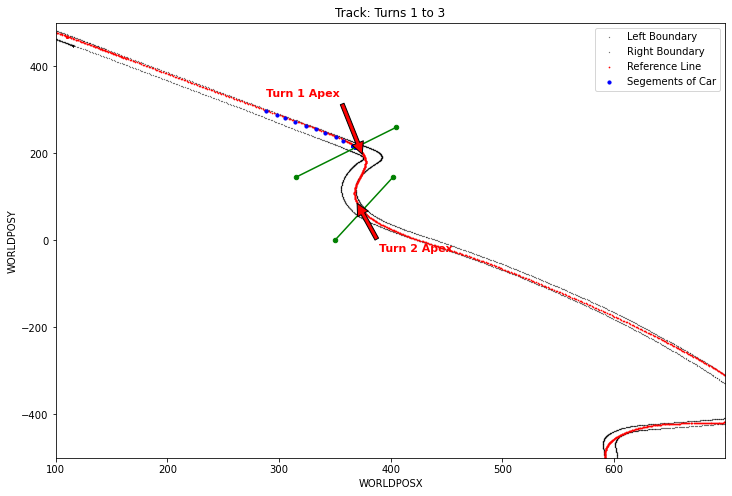

In [40]:
helper.plot_track_with_turns(f1sim_left_df, f1sim_right_df, f1sim_turns, 1, 3, f1sim_line, x_coords, y_coords)

In [41]:
combined_segment_df = pd.merge(combined_segment_df, turns_radial_segment_df, on='INDEX', how='inner')
combined_segment_df

,INDEX,BRAKE_STRAIGHTSEGMENT1,THROTTLE_STRAIGHTSEGMENT1,STEERING_STRAIGHTSEGMENT1,SPEED_KPH_STRAIGHTSEGMENT1,DISTANCE_FROM_REFLINE_STRAIGHTSEGMENT1,DISTANCE_FROM_LEFT_STRAIGHTSEGMENT1,DISTANCE_FROM_RIGHT_STRAIGHTSEGMENT1,LAP_DISTANCE_STRAIGHTSEGMENT1,BRAKE_STRAIGHTSEGMENT2,...,DISTANCE_FROM_RIGHT_TURNSRADIALSEGMENT4,LAP_DISTANCE_TURNSRADIALSEGMENT4,BRAKE_TURNSRADIALSEGMENT5,THROTTLE_TURNSRADIALSEGMENT5,STEERING_TURNSRADIALSEGMENT5,SPEED_KPH_TURNSRADIALSEGMENT5,DISTANCE_FROM_REFLINE_TURNSRADIALSEGMENT5,DISTANCE_FROM_LEFT_TURNSRADIALSEGMENT5,DISTANCE_FROM_RIGHT_TURNSRADIALSEGMENT5,LAP_DISTANCE_TURNSRADIALSEGMENT5
0,388.0,0.000000,0.962173,0.005264,309.0,1.100726,-2.786185,-11.592266,244.538086,0.000000,...,11.123008,358.252197,0.000000,0.273106,0.191211,163.0,-0.895778,-5.906099,10.748856,360.478943
1,389.0,0.000000,1.000000,-0.004257,315.0,-0.453970,2.141060,12.210894,243.563965,0.000000,...,8.115920,359.684570,0.000000,0.283604,0.222522,160.0,-1.757363,9.180130,-7.513386,361.808105
2,390.0,0.000000,1.000000,0.005814,316.0,0.167051,1.850105,-12.588589,246.681641,0.064729,...,-7.770533,361.378906,0.000000,0.789380,0.102129,163.0,-1.651812,8.912086,-7.770533,361.378906
3,391.0,0.000000,0.976471,0.002251,324.0,-0.256447,1.939222,-12.509152,247.017883,0.145098,...,-9.270131,360.076752,0.058824,0.027451,0.317273,150.0,0.484153,7.932365,8.767693,362.102142
4,392.0,0.000000,1.000000,0.001335,324.0,0.657918,-2.344151,12.018500,243.964355,0.000000,...,-10.054263,359.473145,0.976471,0.000000,0.374952,163.0,0.059984,7.201576,9.488224,361.680664
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
749,371.0,0.003983,1.000000,-0.011490,330.0,0.444028,-2.129865,12.240697,244.254883,0.309682,...,8.969581,360.402344,0.000000,0.179919,0.305562,155.0,0.786822,-8.386659,-8.321358,362.458008
750,375.0,0.133074,0.000000,-0.000687,281.0,0.223271,-1.908652,-12.471050,244.589645,0.266148,...,-13.296847,357.984009,0.785489,0.000000,0.040696,166.0,-3.191680,3.443660,-13.205498,360.322876
751,376.0,0.000000,1.000000,-0.018357,329.0,-0.153643,1.841155,-12.505534,243.366699,0.140078,...,10.593516,358.220215,0.000000,0.138247,0.237995,157.0,0.208799,6.581244,10.069408,360.333984
752,377.0,0.000000,0.398413,0.002701,251.0,-0.431949,2.119088,12.232247,243.540604,0.000000,...,6.917570,359.712372,0.000000,0.000000,0.159442,201.0,2.804803,-10.524269,-6.183052,362.402863


### Segment 5 - The next 88 metres around the apex of Turn 2 will be sampled 10 times or roughly every 8.8 metres. (We can expect the car to throttle from the common radius of Turn 1 and Turn 2 as Turn 2 has a more open turning arc so we will need less frequent samples)

In [42]:
intersection_turn2_points = helper.find_all_car_intersection_points_and_closest_points(f1sim_car_df, f1sim_turns, 1, 1)

In [43]:
segments, graphing = helper.generate_segment_data(f1sim_car_df, 
                             intersection_turn1_points, 
                             intersection_turn1_points, 
                             f1sim_line_df,
                             f1sim_left_df,
                             f1sim_right_df,
                             segment_name="TURN2APEX", 
                             offset_start=3, 
                             offset_end=0, 
                             interval_samples=10, 
                             segment_num=5)

In [44]:
turn2_segment_df = pd.DataFrame(segments).T
turn2_segment_df

,INDEX,BRAKE_TURN2APEXSEGMENT1,THROTTLE_TURN2APEXSEGMENT1,STEERING_TURN2APEXSEGMENT1,SPEED_KPH_TURN2APEXSEGMENT1,DISTANCE_FROM_REFLINE_TURN2APEXSEGMENT1,DISTANCE_FROM_LEFT_TURN2APEXSEGMENT1,DISTANCE_FROM_RIGHT_TURN2APEXSEGMENT1,LAP_DISTANCE_TURN2APEXSEGMENT1,BRAKE_TURN2APEXSEGMENT2,...,DISTANCE_FROM_RIGHT_TURN2APEXSEGMENT9,LAP_DISTANCE_TURN2APEXSEGMENT9,BRAKE_TURN2APEXSEGMENT10,THROTTLE_TURN2APEXSEGMENT10,STEERING_TURN2APEXSEGMENT10,SPEED_KPH_TURN2APEXSEGMENT10,DISTANCE_FROM_REFLINE_TURN2APEXSEGMENT10,DISTANCE_FROM_LEFT_TURN2APEXSEGMENT10,DISTANCE_FROM_RIGHT_TURN2APEXSEGMENT10,LAP_DISTANCE_TURN2APEXSEGMENT10
388,388.0,0.000000,0.273106,0.191211,163.0,-0.895778,5.906099,10.748856,360.478943,0.000000,...,11.123008,358.252197,0.000000,0.281498,0.174639,163.0,0.658701,5.448883,11.123008,358.252197
389,389.0,0.000000,0.283604,0.222522,160.0,-1.757363,9.180130,7.513386,361.808105,0.000000,...,8.115920,359.684570,0.000000,0.349783,0.223438,159.0,-1.831765,8.513699,8.115920,359.684570
390,390.0,0.000000,0.415427,0.057084,164.0,1.808265,10.146032,6.595173,364.157227,0.000000,...,8.310633,359.980469,0.000000,0.920165,0.134813,162.0,-1.561846,8.329156,8.310633,359.980469
391,391.0,0.058824,0.027451,0.317273,150.0,0.484153,7.932365,8.767693,362.102142,0.058824,...,9.270131,360.076752,0.121569,0.019608,0.277600,151.0,-0.623902,7.372500,9.270131,360.076752
392,392.0,0.976471,0.000000,0.374952,163.0,0.059984,7.201576,9.488224,361.680664,0.976471,...,10.054263,359.473145,0.976471,0.000000,0.321393,167.0,-0.046494,6.566747,10.054263,359.473145
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
371,371.0,0.000000,0.179919,0.305562,155.0,0.786822,8.386659,8.321358,362.458008,0.000000,...,8.969581,360.402344,0.062898,0.163806,0.299977,155.0,0.814431,7.683674,8.969581,360.402344
375,375.0,0.785489,0.000000,0.040696,166.0,-3.191680,3.443660,13.205498,360.322876,0.785489,...,13.296847,357.984009,0.763470,0.000000,0.040696,171.0,2.681409,3.262011,13.296847,357.984009
376,376.0,0.000000,0.138247,0.237995,157.0,0.208799,6.581244,10.069408,360.333984,0.000000,...,10.593516,358.220215,0.063035,0.024262,0.232136,158.0,0.143253,5.977396,10.593516,358.220215
377,377.0,0.000000,0.000000,0.159442,201.0,2.804803,10.524269,6.183052,362.402863,0.000000,...,6.917570,359.712372,0.000000,0.000000,0.159533,202.0,2.960515,9.713586,6.917570,359.712372


In [45]:
x_coords = x_coords + [sublist[0] for sublist in graphing]
y_coords = y_coords + [sublist[1] for sublist in graphing]                                          

In [46]:
len(x_coords)

40

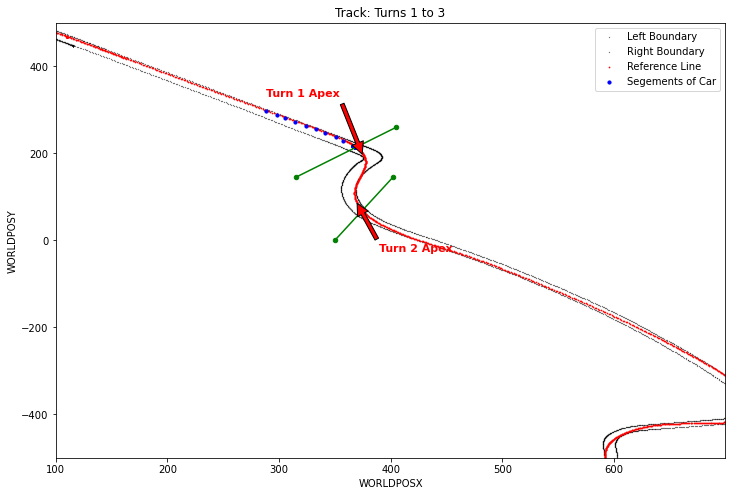

In [47]:
helper.plot_track_with_turns(f1sim_left_df, f1sim_right_df, f1sim_turns, 1, 3, f1sim_line, x_coords, y_coords)

In [48]:
combined_segment_df = pd.merge(combined_segment_df, turn2_segment_df, on='INDEX', how='inner')
combined_segment_df

,INDEX,BRAKE_STRAIGHTSEGMENT1,THROTTLE_STRAIGHTSEGMENT1,STEERING_STRAIGHTSEGMENT1,SPEED_KPH_STRAIGHTSEGMENT1,DISTANCE_FROM_REFLINE_STRAIGHTSEGMENT1,DISTANCE_FROM_LEFT_STRAIGHTSEGMENT1,DISTANCE_FROM_RIGHT_STRAIGHTSEGMENT1,LAP_DISTANCE_STRAIGHTSEGMENT1,BRAKE_STRAIGHTSEGMENT2,...,DISTANCE_FROM_RIGHT_TURN2APEXSEGMENT9,LAP_DISTANCE_TURN2APEXSEGMENT9,BRAKE_TURN2APEXSEGMENT10,THROTTLE_TURN2APEXSEGMENT10,STEERING_TURN2APEXSEGMENT10,SPEED_KPH_TURN2APEXSEGMENT10,DISTANCE_FROM_REFLINE_TURN2APEXSEGMENT10,DISTANCE_FROM_LEFT_TURN2APEXSEGMENT10,DISTANCE_FROM_RIGHT_TURN2APEXSEGMENT10,LAP_DISTANCE_TURN2APEXSEGMENT10
0,388.0,0.000000,0.962173,0.005264,309.0,1.100726,2.786185,11.592266,244.538086,0.000000,...,11.123008,358.252197,0.000000,0.281498,0.174639,163.0,0.658701,5.448883,11.123008,358.252197
1,389.0,0.000000,1.000000,-0.004257,315.0,-0.453970,2.141060,12.210894,243.563965,0.000000,...,8.115920,359.684570,0.000000,0.349783,0.223438,159.0,-1.831765,8.513699,8.115920,359.684570
2,390.0,0.000000,1.000000,0.005814,316.0,0.167051,1.850105,12.588589,246.681641,0.064729,...,8.310633,359.980469,0.000000,0.920165,0.134813,162.0,-1.561846,8.329156,8.310633,359.980469
3,391.0,0.000000,0.976471,0.002251,324.0,-0.256447,1.939222,12.509152,247.017883,0.145098,...,9.270131,360.076752,0.121569,0.019608,0.277600,151.0,-0.623902,7.372500,9.270131,360.076752
4,392.0,0.000000,1.000000,0.001335,324.0,0.657918,2.344151,12.018500,243.964355,0.000000,...,10.054263,359.473145,0.976471,0.000000,0.321393,167.0,-0.046494,6.566747,10.054263,359.473145
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
749,371.0,0.003983,1.000000,-0.011490,330.0,0.444028,2.129865,12.240697,244.254883,0.309682,...,8.969581,360.402344,0.062898,0.163806,0.299977,155.0,0.814431,7.683674,8.969581,360.402344
750,375.0,0.133074,0.000000,-0.000687,281.0,0.223271,1.908652,12.471050,244.589645,0.266148,...,13.296847,357.984009,0.763470,0.000000,0.040696,171.0,2.681409,3.262011,13.296847,357.984009
751,376.0,0.000000,1.000000,-0.018357,329.0,-0.153643,1.841155,12.505534,243.366699,0.140078,...,10.593516,358.220215,0.063035,0.024262,0.232136,158.0,0.143253,5.977396,10.593516,358.220215
752,377.0,0.000000,0.398413,0.002701,251.0,-0.431949,2.119088,12.232247,243.540604,0.000000,...,6.917570,359.712372,0.000000,0.000000,0.159533,202.0,2.960515,9.713586,6.917570,359.712372


In [46]:
combined_segment_df.to_csv(os.path.join(current_dir, '..', 'processed_data', 'f1sim_segment_data.csv'))